# Week 1 notebook

In [17]:
import os
import sys
sys.path.insert(0, os.path.abspath('..'))

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from utils.load_config import load_config
from utils.show_image import show_image
from data_loader.data_loader_generic import DataLoaderGeneric
from models.model_wk1 import ModelWeek1

## Load config

load the config file for this notebook


In [7]:
config = load_config("../config/config_wk1_1.yml")
config

{'image_size': 50,
 'epochs': 100,
 'data_sets': {'week1_data_train': {'data_files': [{'file': '../data/A.m1.dir.tar.gz',
     'labels': {0: 0},
     'default_label': 1},
    {'file': '../data/A.i.m1.dir.tar.gz', 'default_label': 2}]}},
 'data_train_split': 0.8,
 'data_validation_split': 0.8,
 'data_batch_size': 32,
 'data_num_classes': 3}

## Create dataloader

The dataset for this notebook is specified in the `week1_data_train` key in the config

In [8]:
data_loader = DataLoaderGeneric(config)

train_data_set, test_data_set, validation_data_set = data_loader.load_data_set("week1_data_train")

## Create model

create a model like

```
model = Sequential([
    Conv2D(32, kernel_size=(3, 3),activation='relu', input_shape=(image_size, image_size, 1)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])
```

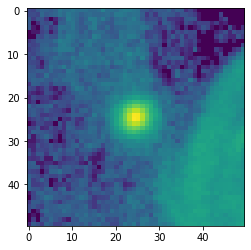

In [18]:
show_image(train_data_set)

In [19]:
model_wk1 = ModelWeek1(config)
model = model_wk1.get_uncompiled_model()
model = model_wk1.compile_model(model)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 23, 23, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 33856)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               4333696   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

## Train model

In [39]:
epochs = min(config.get("epochs", 100), 40)

model.fit(
    train_data_set,
    steps_per_epoch=50,
    epochs=epochs,
    validation_data=validation_data_set,
    validation_steps=50,
    verbose=1,
)

Train for 50 steps, validate for 50 steps
Epoch 1/40
50/50 [==============================] - 11s 214ms/step - loss: 0.9408 - accuracy: 0.6981 - val_loss: 0.9319 - val_accuracy: 0.7713
Epoch 2/40
50/50 [==============================] - 10s 209ms/step - loss: 0.9347 - accuracy: 0.6969 - val_loss: 0.9295 - val_accuracy: 0.7656
Epoch 3/40
50/50 [==============================] - 10s 208ms/step - loss: 0.9368 - accuracy: 0.7006 - val_loss: 0.9252 - val_accuracy: 0.7725
Epoch 4/40
50/50 [==============================] - 10s 208ms/step - loss: 0.9273 - accuracy: 0.7250 - val_loss: 0.9233 - val_accuracy: 0.7669
Epoch 5/40
50/50 [==============================] - 11s 218ms/step - loss: 0.9233 - accuracy: 0.7138 - val_loss: 0.9230 - val_accuracy: 0.7625
Epoch 6/40
50/50 [==============================] - 12s 233ms/step - loss: 0.9269 - accuracy: 0.7119 - val_loss: 0.9157 - val_accuracy: 0.7756
Epoch 7/40
50/50 [==============================] - 12s 234ms/step - loss: 0.9188 - accuracy: 0.7188

In [32]:
model_wk1.save_model_and_weights_to_disk(model, "model_80.json", "model_80.h5")

## Analyse Model

In [40]:
correct_labels = []
predicted_labels = []

for image, label in test_data_set:
    predicted = model.predict(image)

    for val in label.numpy(): correct_labels.append(val[0])
    for val in predicted: predicted_labels.append(np.argmax(val))
    # predicted_labels.append(predicted)

### Plot confusion matrix

It seems the model has trouble differentiating the isolated galaxy and a tidal interation

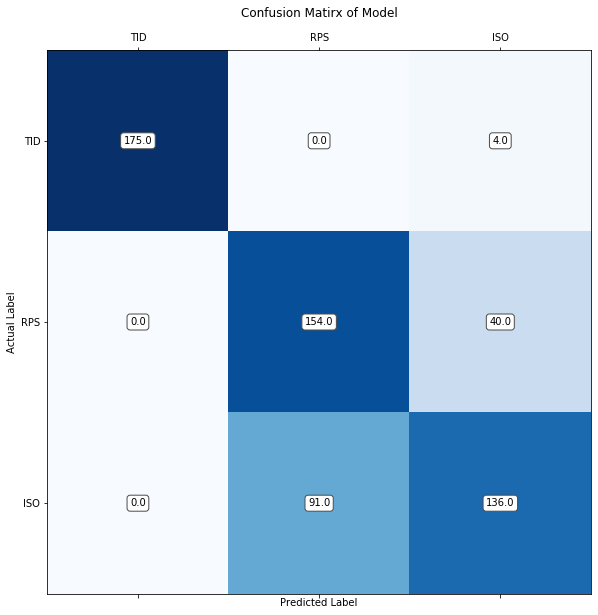

In [41]:
conf_mtrx = confusion_matrix(correct_labels, predicted_labels)
labels = ['TID', 'RPS', 'ISO']

fig, ax = plt.subplots(figsize=(10, 10))

# Using matshow here just because it sets the ticks up nicely. imshow is faster.
ax.matshow(conf_mtrx, cmap="Blues")

for (i, j), z in np.ndenumerate(conf_mtrx):
    ax.text(
        j,i, 
        '{:0.1f}'.format(z),
        ha='center',
        va='center',
        bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))

ax.set_xticklabels(['']+labels)
ax.set_yticklabels(['']+labels)
ax.set_xlabel("Predicted Label")
ax.set_ylabel("Actual Label")


plt.title("Confusion Matirx of Model")

plt.show()

In [42]:
!rm -rf ./images

In [43]:
!mkdir -p images

from PIL import Image 

counts = [0, 0, 0]

label_names = ["TID", "RPS", "ISO"]
for image, label in test_data_set:
    predicted = model.predict(image)

    for i in range(image.shape[0]):
        val = label[i].numpy()[0]
        pre_val = np.argmax(predicted[i])
        if val != pre_val:
            im_size = image[i].shape[0]
            img = image[i].numpy().reshape(im_size, im_size) * 255
            img = Image.fromarray(img).convert("L")
            counts[val] += 1
            img.save(f"images/val_{label_names[val]}__pre_{label_names[pre_val]}_{str(counts[val]).zfill(4)}.jpg")

print(counts)
            

[4, 40, 91]


In [4]:
import tarfile
import numpy as np

with tarfile.open("../data/A.m1.dir.tar.gz") as a:
    f = a.extractfile("m1.dir/2dftn1.dat")
    d = np.loadtxt(f, dtype=np.float32)

print(d[0])

7.0845127


In [219]:
d = d.reshape(2000,50,50)

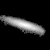

In [220]:
Image.fromarray(d[999]*255).convert("L")